### Notebook for initializing polymer systems using a DPD potential

In [1]:
import matplotlib
import numpy as np  
import scipy.stats
import gsd, gsd.hoomd 
import freud 
import math
import itertools 
import hoomd 
import fresnel 
%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
import time

In [3]:
def render(frame): 
    '''
    Visualize a simulation box within a jupyter notebook.
    
    '''
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = np.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        bond_distances = np.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = np.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
                
    return fresnel.preview(scene)

In [4]:
def initialize_snapshot(num_pol, num_mon, density=0.85):
    '''
    Create a HOOMD snapshot of a cubic box with the number density given by input parameters.

    '''
    N = num_pol * num_mon
    L = np.cbrt(N / density)  # Calculate box size based on density
    buffer = 4
    print(L)
    #TODO: change to random walk
    positions = np.random.uniform(low=-(0.5), high=(0.5), size=(N, 3))
    bonds = []
    for i in range(num_pol):
        start = i * num_mon
        for j in range(num_mon - 1):
            bonds.append([start + j, start + j + 1])
    bonds = np.array(bonds)
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['A']
    frame.particles.N = N
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    frame.configuration.box = [L, L, L, 0, 0, 0]
    return frame

In [68]:
def initialize_snapshot_rand_walk(num_pol, num_mon, density=0.85):
    '''
    Create a HOOMD snapshot of a cubic box with the number density given by input parameters.

    '''    
    N = num_pol * num_mon
    L = np.cbrt(N / density)  # Calculate box size based on density
    buffer = 4
    bond_length = 1.0
    print(L)
    #TODO: change to random walk
    #positions = np.random.uniform(low=-(0.5), high=(0.5), size=(N, 3))
    positions = np.zeros((N, 3))
    for i in range(num_pol):
        start = i * num_mon
        positions[start] = np.random.uniform(low=(-L/2),high=(L/2),size=3)
        for j in range(num_mon - 1):
            positions[start+j+1] = positions[start+j] + np.random.uniform(low=(-bond_length/2),high=(bond_length/2),size=3)
    #print(positions)
    positions = pbc(positions,[L,L,L])
    #print(positions)
    bonds = []
    for i in range(num_pol):
        start = i * num_mon
        for j in range(num_mon - 1):
            bonds.append([start + j, start + j + 1])
    bonds = np.array(bonds)
    frame = gsd.hoomd.Frame()
    frame.particles.types = ['A']
    frame.particles.N = N
    frame.particles.position = positions
    frame.bonds.N = len(bonds)
    frame.bonds.group = bonds
    frame.bonds.types = ['b']
    frame.configuration.box = [L, L, L, 0, 0, 0]
    return frame

In [5]:
def pbc(d,box):
    for i in range(3):
        a = d[:,i]
        a[a < -box[i]/2] += box[i]
        a[a >  box[i]/2] -= box[i]
    return d

In [6]:
def check_bond_length_equillibration(gsdfile,bond_length,num_mon,num_pol):
    fene_bond_l = bond_length
    traj = gsd.hoomd.open(gsdfile)
    last_frame = traj[-1]
    frame_ds = []
    for j in range(num_pol):
        idx = j*num_mon
        d1 = last_frame.particles.position[idx:idx+num_mon-1] - last_frame.particles.position[idx+1:idx+num_mon]
        bond_l = np.linalg.norm(pbc(d1,frame.configuration.box),axis=1)
        frame_ds.append(bond_l)
    max_frame_bond_l = np.max(np.array(frame_ds))
    min_frame_bond_l = np.min(np.array(frame_ds))
    print("max: ",max_frame_bond_l," min: ",min_frame_bond_l)
    if max_frame_bond_l <= fene_bond_l and min_frame_bond_l >= (fene_bond_l - 0.3):
        print("DPD Simulation Finished.")
        return True
    if max_frame_bond_l > fene_bond_l or min_frame_bond_l < (fene_bond_l - 0.3):
        return False

80000

Running with A=3000.0, gamma=1000.0, k=10000.0, num_pol=1000, num_mon=80
44.6288633388113
Total build time:  0.20570533303543925
max:  3.7157393  min:  0.20789962
max:  1.0790449  min:  0.9056852
DPD Simulation Finished.
Finished in 2000 iterations. Total time = 24.34s


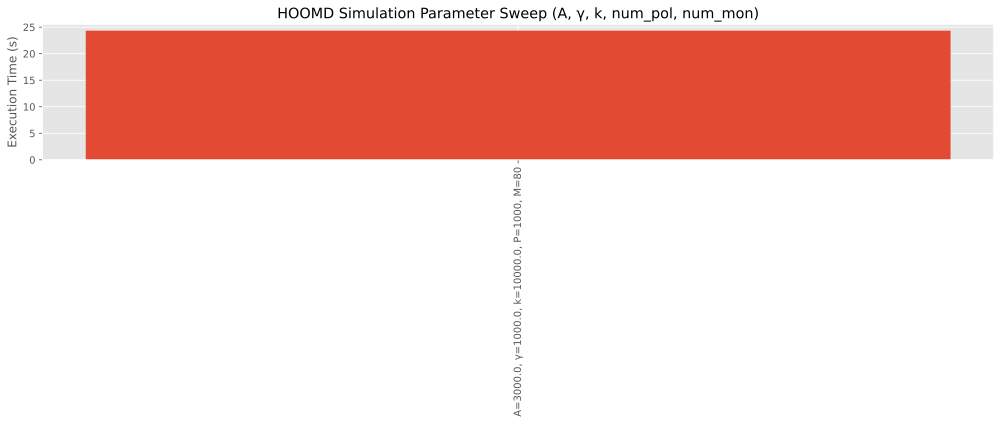

In [88]:
import time
import hoomd
import numpy as np
import matplotlib.pyplot as plt
import csv

# --- your helper functions (assumed already defined) ---
# initialize_snapshot(...)
# check_bond_length_equillibration(...)
# render(...)

# --- parameter ranges to sweep ---
A_values = [3000.0]       # vary interaction strength
gamma_values = [1000.0]      # vary friction
polymer_sizes = [(1000,80)]  # (num_pol, num_mon)
k_values = [10000.0]            # vary bond spring constant

results = []

for A in A_values:
    for gamma in gamma_values:
        for num_pol, num_mon in polymer_sizes:
            for k in k_values:
                #A = (num_pol*num_mon*3)/10
                print(num_pol*num_mon)
                print(f"\nRunning with A={A}, gamma={gamma}, k={k}, "
                      f"num_pol={num_pol}, num_mon={num_mon}")
                
                # ---- start timing ----
                start_time = time.perf_counter()

                kT = 1.0
                cut = 1.15
                l = 1.0
                timestep = 0.001
                density = 0.9
                build_start = time.perf_counter()
                frame = initialize_snapshot_rand_walk(num_pol, num_mon, density=density)
                build_stop = time.perf_counter()
                print("Total build time: ", build_stop-build_start)
                
                # Bond potential
                harmonic = hoomd.md.bond.Harmonic()
                harmonic.params["b"] = dict(r0=l, k=k)

                integrator = hoomd.md.Integrator(dt=timestep)
                integrator.forces.append(harmonic)

                simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=12)
                simulation.operations.integrator = integrator 
                simulation.create_state_from_snapshot(frame)

                const_vol = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
                integrator.methods.append(const_vol)

                # Neighbor list + forcefield
                nlist = hoomd.md.nlist.Cell(buffer=0.4)
                simulation.operations.nlist = nlist

                DPD = hoomd.md.pair.DPD(nlist, default_r_cut=cut, kT=kT)
                DPD.params[('A', 'A')] = dict(A=A, gamma=gamma)
                integrator.forces.append(DPD)

                gsd_file = f'run_len_{num_mon}_pol_{num_pol}_A{int(A)}_g{int(gamma)}_k{k}.gsd'
                gsd_out = hoomd.write.GSD(
                    trigger=hoomd.trigger.Periodic(10), 
                    mode='wb',
                    dynamic=['property','momentum'],
                    filename=gsd_file,
                    truncate=False)
                simulation.operations.writers.append(gsd_out)

                # --- Run simulation ---
                simulation.run(100)
                gsd_out.flush()

                fene_bond_l = 1.1
                count = 1000
                while not check_bond_length_equillibration(gsd_file, fene_bond_l, num_mon, num_pol):
                    check_time = time.perf_counter()
                    #if (check_time-start_time) > 60:
                    #    break
                    simulation.run(1000)
                    gsd_out.flush()
                    count += 1000

                end_time = time.perf_counter()
                elapsed = end_time - start_time

                print(f"Finished in {count} iterations. Total time = {elapsed:.2f}s")

                # Store results
                results.append({
                    "A": A,
                    "gamma": gamma,
                    "k": k,
                    "num_pol": num_pol,
                    "num_mon": num_mon,
                    "iterations": count,
                    "time": elapsed
                })

# --- Save results ---
with open("sweep_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["A", "gamma", "k", "num_pol", "num_mon", "iterations", "time"])
    writer.writeheader()
    writer.writerows(results)

# --- Plot results ---
times = [r["time"] for r in results]
labels = [f"A={r['A']}, γ={r['gamma']}, k={r['k']}, "
          f"P={r['num_pol']}, M={r['num_mon']}" for r in results]

plt.figure(figsize=(14,6))
plt.bar(range(len(results)), times)
plt.xticks(range(len(results)), labels, rotation=90)
plt.ylabel("Execution Time (s)")
plt.title("HOOMD Simulation Parameter Sweep (A, γ, k, num_pol, num_mon)")
plt.tight_layout()
plt.savefig("sweep_results.png", dpi=200)
plt.show()

## Parameters

In [33]:
num_pol = 50
num_mon = 50
kT = 2.0
cut = 2.5
l = 1.0 #bond length r_0
timestep = 0.001
gamma = 0.1 #DPD parameter
A = 50.0 #DPD parameter

## HOOMD simulation code

In [89]:
start_time = time.perf_counter()
num_pol = 400
num_mon = 40
kT = 1.0
cut = 1.2
l = 1.0 #bond length r_0
timestep = 0.001
gamma = 400.0 #DPD parameter
A = 5000.0 #DPD parameter, A scales down with N
k=10000
density = 0.9

frame = initialize_snapshot(num_pol, num_mon, density=density)

#assign harmonic bond potentials
harmonic = hoomd.md.bond.Harmonic()
harmonic.params["b"] = dict(r0=l, k=k)

integrator = hoomd.md.Integrator(dt=timestep)
integrator.forces.append(harmonic)

#initialize HOOMD simulation object
simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=12)
simulation.operations.integrator = integrator 
simulation.create_state_from_snapshot(frame) #create initial state of Simulation

#add ensemble method to Simulation
const_vol = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(const_vol)

#define the neighbor list
nlist = hoomd.md.nlist.Cell(buffer=0.4)
simulation.operations.nlist = nlist

#define the forcefield
DPD = hoomd.md.pair.DPD(nlist, default_r_cut=cut, kT=kT)
DPD.params[('A', 'A')] = dict(A=A, gamma=gamma)
integrator.forces.append(DPD)
simulation.operations.integrator = integrator

#define write frequency for trajectory file
gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(10), 
    mode='wb',
    dynamic=['property','momentum'],
    filename='run_len_%s_pol_%s.gsd'%(num_mon,num_pol),
    truncate=False)
simulation.operations.writers.append(gsd_out)

#run the simulation! and log by flushing the writers
simulation.run(100)
gsd_out.flush()

fene_bond_l = 1.2
file = 'run_len_%s_pol_%s.gsd'%(num_mon,num_pol)
count = 1000


while not check_bond_length_equillibration(file,fene_bond_l,num_mon,num_pol):
    simulation.run(1000)
    gsd_out.flush()
    count += 1000
end_time = time.perf_counter()
render(simulation.state.get_snapshot())
print(f"Finished in {count} iterations.")
print("Total time: ", end_time-start_time)

26.099117607792426
max:  8.352424  min:  0.18233934
max:  2.1499987  min:  0.76625943
max:  1.3534541  min:  0.8834333
max:  1.3140472  min:  0.9083489
max:  1.2338952  min:  0.87926334
max:  1.2147399  min:  0.92078745
max:  1.1964926  min:  0.90998447
DPD Simulation Finished.
Finished in 7000 iterations.


## Run code

In [37]:
#run the simulation! and log by flushing the writers
simulation.run(1_000)
gsd_out.flush()

fene_bond_l = 1.2
file = 'run_len_%s_pol_%s.gsd'%(num_mon,num_pol)
count = 1000


while not check_bond_length_equillibration(file,fene_bond_l,num_mon,num_pol):
    simulation.run(200)
    gsd_out.flush()
    count += 200
render(simulation.state.get_snapshot())
print(f"Finished in {count} iterations.")

max bond length:  7.683396
min bond length:  0.23592383
max bond length:  7.369175
min bond length:  0.21894705
max bond length:  7.587952
min bond length:  0.27974385
max bond length:  7.50972
min bond length:  0.2194792
max bond length:  8.6888075
min bond length:  0.16744503
max bond length:  7.4796405
min bond length:  0.14268649
max bond length:  7.717604
min bond length:  0.15104882
max bond length:  7.7832747
min bond length:  0.21767738
max bond length:  7.772977
min bond length:  0.2623106
max bond length:  7.37987
min bond length:  0.16633241
max bond length:  7.5375447
min bond length:  0.17321211
max bond length:  7.41851
min bond length:  0.14127648
max bond length:  7.1190305
min bond length:  0.3377385
max bond length:  6.418019
min bond length:  0.19830942
max bond length:  7.3047056
min bond length:  0.2899017
max bond length:  6.6087494
min bond length:  0.20736666
max bond length:  6.550147
min bond length:  0.28899005
max bond length:  6.0029664
min bond length:  0.

KeyboardInterrupt: 

### Graph the bond length relaxation

In [46]:
np.random.seed(seed=4)
for i in range(10):
    print(np.random.random())
    

0.9670298390136767
0.5472322491757223
0.9726843599648843
0.7148159936743647
0.6977288245972708
0.21608949558037638
0.9762744547762418
0.006230255204589863
0.25298236238344396
0.4347915324044458


In [ ]:
import matplotlib.pyplot as plt

with gsd.hoomd.open('run_len_%s_pol_%s.gsd'%(num_mon,num_pol),'r') as traj:
    avg_frame_bond_l = []
    for frame in traj:
        bond_l = []
        for i in range(0,num_mon-2):
            dr = np.linalg.norm((frame.particles.position[i+1] - frame.particles.position[i]), axis=0)
            bond_l.append(dr)
        avg_frame_bond_l.append(np.mean(bond_l))

plt.plot(avg_frame_bond_l)

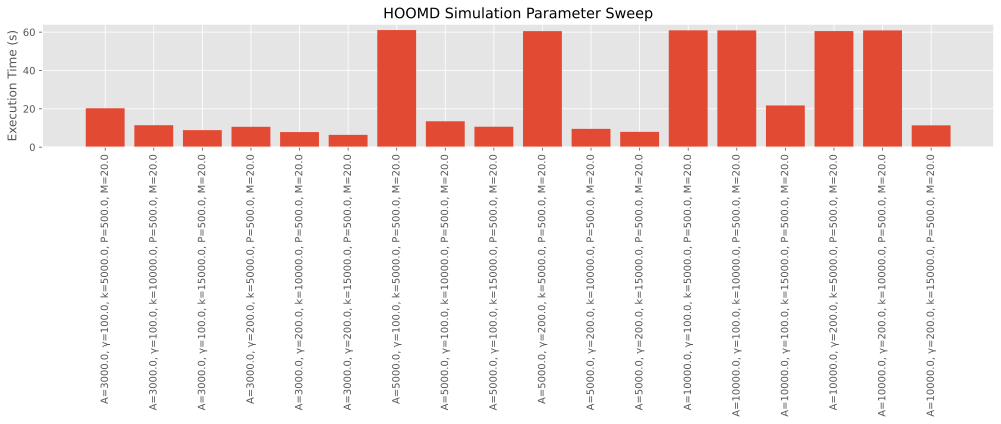

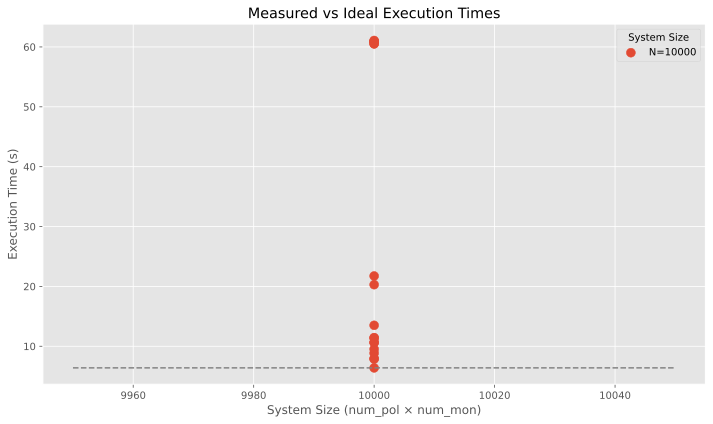

In [19]:
import pandas as pd

# Save results
with open("sweep_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["A", "gamma", "k", "num_pol", "num_mon", "iterations", "time", "status"])
    writer.writeheader()
    writer.writerows(results)

# Load into DataFrame for analysis
df = pd.DataFrame(results)

# Compute system size
df["system_size"] = df["num_pol"] * df["num_mon"]

# --- Plot measured runtimes ---
plt.figure(figsize=(14,6))
plt.bar(range(len(df)), df["time"].fillna(0))
labels = [f"A={r['A']}, γ={r['gamma']}, k={r['k']}, "
          f"P={r['num_pol']}, M={r['num_mon']}" for _, r in df.iterrows()]
plt.xticks(range(len(df)), labels, rotation=90)
plt.ylabel("Execution Time (s)")
plt.title("HOOMD Simulation Parameter Sweep")
plt.tight_layout()
plt.savefig("sweep_results.png", dpi=200)
plt.show()

# --- Ideal scaling line (time ~ N) ---
# get best time per particle as reference
valid = df.dropna(subset=["time"])
min_time_per_particle = (valid["time"] / valid["system_size"]).min()

df["ideal_time"] = df["system_size"] * min_time_per_particle

# --- Graph: actual vs ideal ---
plt.figure(figsize=(10,6))
for size in sorted(df["system_size"].unique()):
    subset = df[df["system_size"] == size]
    plt.scatter(subset["system_size"], subset["time"], label=f"N={size}", s=80)
    plt.hlines(subset["ideal_time"].iloc[0], xmin=size-50, xmax=size+50,
               colors="gray", linestyles="dashed")

plt.xlabel("System Size (num_pol × num_mon)")
plt.ylabel("Execution Time (s)")
plt.title("Measured vs Ideal Execution Times")
plt.legend(title="System Size")
plt.tight_layout()
plt.savefig("ideal_scaling.png", dpi=200)
plt.show()


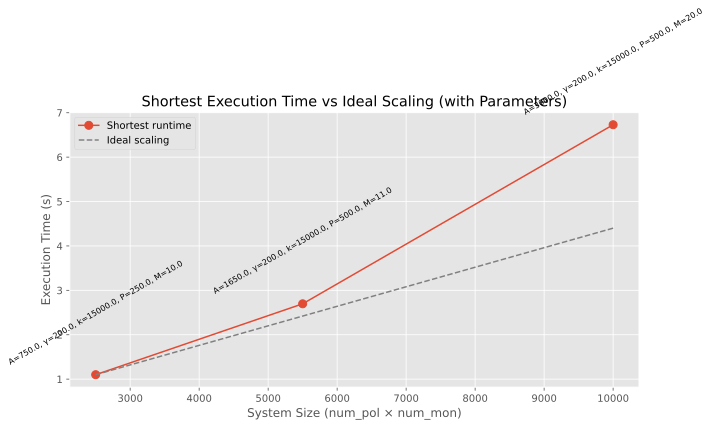

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.DataFrame(results)

# Compute system size
df["system_size"] = df["num_pol"] * df["num_mon"]

# Drop failed runs
valid = df.dropna(subset=["time"])

# --- Find shortest execution time per system size ---
best = valid.loc[valid.groupby("system_size")["time"].idxmin()]

# --- Define ideal scaling (linear in system size) ---
min_time_per_particle = (best["time"] / best["system_size"]).min()
best["ideal_time"] = best["system_size"] * min_time_per_particle

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(best["system_size"], best["time"], "o-", label="Shortest runtime", markersize=8)
plt.plot(best["system_size"], best["ideal_time"], "--", color="gray", label="Ideal scaling")

# Annotate each best point with its parameters
for _, row in best.iterrows():
    label = f"A={row['A']}, γ={row['gamma']}, k={row['k']}, P={row['num_pol']}, M={row['num_mon']}"
    plt.annotate(label,
                 (row["system_size"], row["time"]),
                 textcoords="offset points",
                 xytext=(0,10),  # vertical offset
                 ha="center",
                 fontsize=8,
                 rotation=30)

plt.xlabel("System Size (num_pol × num_mon)")
plt.ylabel("Execution Time (s)")
plt.title("Shortest Execution Time vs Ideal Scaling (with Parameters)")
plt.legend()
plt.tight_layout()
plt.savefig("best_vs_ideal_annotated.png", dpi=200)
plt.show()
